<center><img align="center" src="https://media-exp1.licdn.com/dms/image/C4D0BAQEn1scYwvaKig/company-logo_200_200/0?e=2159024400&v=beta&t=sVP5pKEO7FUUV3fV8mh5MtlEyz-SBF6NZpIlyZcVKnk" alt="PUC Minas">

# <center>Ciência de Dados e Big Data - Trabalho de Conclusão de Curso</center>

## <center>Impacto do COVID-19 nas empresas de transporte aéreo brasileiras</center>

### <center>Diego Emerick Sousa</center>
---
<center>Trabalho desenvolvido para conclusão do curso em Ciências de Dados e Big Data na PUC Minas

# 1 - Bilbiotecas

In [106]:
!pip install yfinance
!pip install scikit-learn
!pip install fbprophet
!pip install pmdarima

In [107]:
from plotly.offline import plot, iplot
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from fbprophet import Prophet
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly
import plotly.offline as py
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import math


In [108]:
#habilita o modo offline
py.init_notebook_mode(connected=True)
pio.renderers
pio.renderers.default = "colab"

# 2 - Obtendo dados do Yahoo Finance

In [109]:
# Metódo para coleta de dados

def get_company_history(stock, start, end, index):
  market_share = yf.Ticker(stock)
  market_share_history = market_share.history(
      start=start, 
      end=end)
  
  if (index == True):
    market_share_history = market_share_history.reset_index()

  return market_share_history

In [110]:
# Dataset AZUL
dataset_azul = get_company_history(stock="AZUL4.SA", start="2019-07-01", end="2020-11-01", index=True)
#dataset_azul = get_company_history(stock="AZUL4.SA", start="2019-07-01", end="2021-02-01", index=True)
#dataset_azul.count
#data_set_embraer.isnull().sum()

In [111]:
# Dataset GOL
dataset_gol = get_company_history(stock="GOLL4.SA", start="2019-07-01", end="2020-11-02", index=True)
#dataset_gol = get_company_history(stock="GOLL4.SA", start="2019-07-01", end="2021-02-01", index=True)
#dataset_gol.count
#data_set_embraer.isnull().sum()

In [112]:
# Dataset EMBRAER
dataset_embraer = get_company_history(stock="EMBR3.SA", start="2019-07-01", end="2020-11-02", index=True)
#dataset_embraer = get_company_history(stock="EMBR3.SA", start="2019-07-01", end="2021-02-01", index=True)
#dataset_embraer.count
#data_set_embraer.isnull().sum()

# 3 - Criando apresentacao dos dados

## 3.1 - Gráficos para exploração dos dados

In [113]:
def diff_sub_chart(df, a, b):
  df['Diff'] = df[a].sub(df[b])
  fig = px.line(df, x='Date', y="Diff")
  fig.update_layout(height = 600, width = 1500)
  fig.show()

In [114]:
def candle_chart(df):
  trace  = go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'])
  fig = go.Figure(data=[trace])
  fig.update_layout(height = 600, width = 1000)
  
  iplot(fig, filename="Market Share Variation Value")

In [115]:
def variation_chart(df):
  trace = go.Scatter(
      x=df['Date'], 
      y=df['Close'],
      name = "Stock Close In Period",
      opacity = 0.8,
      line = dict(color = '#17BECF'))
  fig = go.Figure(data=[trace])
  fig.update_layout(height = 600, width = 1000)

  iplot(fig, filename="Market variation")

In [116]:
def correlation_chart(df, x, y):
  x = df[x]
  y = df[y]
  plt.scatter(x, y, color='b')
  plt.xlabel('Valor A')
  plt.ylabel('Valor B')
  plt.axis([min(x),max(x),min(y),max(y)])
  plt.autoscale('False')
  plt.show()

In [117]:
def values_comparission_chart(df, x, y, lines):
  fig = px.line(df, x=x, y=y)
  
  for i in lines:
    fig.add_scatter(x=df[x], y=df[i], mode='lines', name=i)
  
  fig.update_layout(height = 600, width = 800)
  fig.show()

## 3.2 - Gráficos para representação da predição

# 4 - Modelo Preditivo


In [118]:
non_use_columns =  ["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"]

## 4.1 Treino

In [119]:
def train(df, features, target):
  training = df[features]
  real_close = df[target]

  X_treino, X_teste, y_treino, y_teste = train_test_split(training, real_close, random_state=42)

  lr_model = linear_model.LinearRegression()
  lr_model.fit(X_treino, y_treino)

  lr_model.predict(X_teste)

  RMSE = mean_squared_error(y_teste, lr_model.predict(X_teste))**0.5
  return RMSE

## 4.2 Facebook Prophet

In [120]:
# Funcao tem o objetivo de remover as colunas nao utilizadas do dataset
# e retonar um novo dataframe para ser usado na funcao do Facebook Prophet

def create_dataset_facebook_prophet(dataset):
  dataset = dataset.drop(columns = non_use_columns)

  return pd.DataFrame({"ds": dataset.index, "y": dataset.Close})

In [121]:
# Esse metodo tem o objetivo de criar a predicao
# utilizando o Facebook Prophet

def make_model_prophet(dataset):
  model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
  
  return model.fit(dataset)

In [122]:
def make_forecast_in_period(model, period):
  return model.make_future_dataframe(periods=period, freq='D')

In [123]:
# Funcao tem o objetivo de plotar o grafico
# de previsao

def plot_prophet(model, forecast, title, xlabel, ylabel):
  fig = model.plot(forecast)
  ax1 = fig.gca()
  ax1.set_title(title, fontsize=16)
  ax1.set_xlabel(xlabel, fontsize=12)
  ax1.set_ylabel(ylabel, fontsize=12)

In [124]:
# Seleciona os dados previstos para o periodo de teste

def get_test_period(forecast, end_date):
  return forecast[forecast['ds'] > end_date]

In [125]:
def plot_forest_components(model, forecast):
 fig = model.plot_components(forecast)

In [126]:
# Realiza a apresentacao dos dados de treino e teste
# em um so grafico para comparacao, utilizando duas visoes

def plot_compar_data_train_test(dataset_train, dataset_test, forecast, title, xlabel, ylabel, save=False):
  n = dataset_train.shape[0]
  plt.figure(figsize=(14,8))
  plt.title(title)
  plt.plot(dataset_train['y'], 'green', label='Dados de treinamento')
  plt.plot(dataset_test['y'], color = 'blue', label='Dados de teste')
  plt.plot(forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
  plt.fill_between(forecast.index[-n:], forecast['yhat_lower'][-n:], forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Range da variação")
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  
  if (save == True):
    plt.savefig('plot.pdf')

  plt.grid(True)

  # Plotagem do comparativo entre o preço previsto e o preço de validação
  plt.figure(figsize=(14,8))
  plt.plot(dataset_test['y'], color = 'blue', label='Dados de teste')
  plt.plot(forecast['yhat'], color = 'red', label = 'Dados previstos')
  plt.fill_between(forecast.index[-n:], forecast['yhat_lower'][-n:], forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Range da variação")
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.grid(True)
  
  if(save == True):
    plt.savefig('plot_zoom.pdf')

  plt.show()

## 4.3 Arima

In [127]:
def decompse_dataset(dataset, period):
  decomposition = seasonal_decompose(dataset, model='multiplicative', period=period)
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid
  
  plt.figure(figsize=(16,10))
  plt.subplot(411)
  plt.plot(dataset)
  plt.ylabel('Original')
  plt.subplot(412)
  plt.plot(trend)
  plt.ylabel('Trend')
  plt.subplot(413)
  plt.plot(seasonal)
  plt.ylabel('Seasonality')
  plt.subplot(414)
  plt.plot(residual)
  plt.ylabel('Residuals')
  plt.tight_layout()
  plt.show()

In [128]:
def correlation_close_variable(title, dataset):
  fig, axes = plt.subplots(3, 2, figsize=(12, 18))
  plt.title(title)
  ax_idcs = [
      (0, 0),
      (0, 1),
      (1, 0),
      (1, 1),
      (2, 0),
      (2, 1)
  ]

  for lag, ax_coords in enumerate(ax_idcs, 1):
      ax_row, ax_col = ax_coords
      axis = axes[ax_row][ax_col]
      lag_plot(dataset["Close"], lag=lag, ax=axis)
      axis.set_title(f"Lag={lag}")

  plt.show()

In [129]:
def adf_test(y):
  print('Resultado do Teste Dickey-Fuller:')
  dftest = adfuller(y, autolag="AIC")
  dfoutput = pd.Series(dftest[0:4], index=['Teste','Valor p', 'Nº de lags', 'Nº de observações'])
  for key, value in dftest[4].items():
      dfoutput['Valor Crítico ({})'.format(key)] = value
  print(dfoutput)

In [130]:
def apply_diff_dataset(dataset):
  dataset_diff = dataset.sub(dataset.shift())
  dataset_diff.dropna(inplace=True)

  return dataset_diff

In [131]:
def plot_diff(title, dataset):
  plt.figure(figsize=(16,8))
  plt.plot(dataset)
  plt.title(title)
  plt.grid(True)

In [132]:
def plot_acf_pacf(dataset):
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
  plot_acf(dataset, ax = ax1)
  plot_pacf(dataset, ax = ax2)
  plt.show()

In [133]:
def create_arima_model(dataset):
  model = auto_arima(
      dataset['Close'], 
      start_p=1, 
      start_q=1,
      #test='adf',                  # usa o adftest para encontrar o melhor valor 'd'
      max_p=3, max_q=3,             # Máximo 'p' e 'q'
      m=12,                         # Frequência da série
      d=1,           
      stationary = False,           #Estacionaridade
      seasonal=True,                #Sazonalidade
      start_P=0, 
      D=1, 
      trace=True,                   #Se TRUE, a lista de modelos ARIMA considerados será reportada.
      error_action='ignore',  
      suppress_warnings=True, 
      stepwise=True)                #Se TRUE, fará a seleção gradual (mais rápido). Caso contrário, ele pesquisará todos os modelos.

  return model.fit(dataset['Close'])

In [134]:
# Realiza a predicao
def create_prediction_arima(model, dataset):
  forecast_arima = model.predict(n_periods=len(dataset['Close']))
  forecast_arima = pd.DataFrame(forecast_arima, index = dataset.index,columns=['Prediction'])
   
  return forecast_arima

In [135]:
def get_conf(model, dataset_test):
  return model.predict(len(dataset_test['Close']), return_conf_int=True, alpha = 0.05)

In [136]:
def plot_arima_predict(dataset_train, 
                       dataset_test,
                       forecast,
                       conf,
                       title, 
                       xlabel, 
                       ylabel,
                       save = False):
  plt.figure(figsize=(14,8))
  plt.title(title)
  plt.plot(dataset_train['Close'], color='green', label = 'Dados de treinamento')
  plt.plot(dataset_test['Close'], color = 'blue', label = 'Dados de teste')
  plt.fill_between(dataset_test.index, conf[1][:,0], conf[1][:,1], color='k', alpha=.08)
  plt.plot(forecast['Prediction'], color = 'red', label = 'Dados previstos')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.grid(True)
  
  if (save == True):
    plt.savefig('plot_arima.pdf')

  plt.show()

In [137]:
def plot_test_predict(dataset_test, 
                      forecast, 
                      conf, 
                      title, 
                      xlabel, 
                      ylabel, 
                      save = False):
  #Plotagem dos dados de teste e previsão
  plt.figure(figsize=(14,8))
  plt.title(title)
  plt.plot(dataset_test['Close'], color = 'blue', label = 'Dados de teste')
  plt.fill_between(dataset_test.index, conf[1][:,0], conf[1][:,1], color='k', alpha=.08)
  plt.plot(forecast['Prediction'], color = 'red', label = 'Dados previstos')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.grid(True)
  
  if (save == True):
    plt.savefig('plot_arima_test.pdf')

  plt.show()

In [138]:
def print_score_confidencility(dataset_test, forecast):
  mse = mean_squared_error(dataset_test['Close'], forecast['Prediction'])
  print('MSE: '+str(mse))
  mae = mean_absolute_error(dataset_test['Close'], forecast['Prediction'])
  print('MAE: '+str(mae))
  rmse = math.sqrt(mean_squared_error(dataset_test['Close'], forecast['Prediction']))
  print('RMSE: '+str(rmse))

# 5 - Estudo de caso

In [139]:
features = ['Open', 'Close', 'Low', 'High']

train_start_date = '2019-11-01'
train_end_date = '2020-08-01'

test_start_date = '2020-08-02'
test_end_date = '2020-11-01'

## 5.1 Azul


In [140]:
## Variação do encerramento da ação no período
variation_chart(dataset_azul)

In [141]:
## Comparação entre os valores da ação no período
values_comparission_chart(dataset_azul, 'Date', 'Open', features)

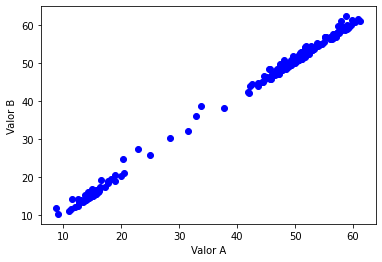

In [142]:
## Correlação entre os valores
correlation_chart(dataset_azul[:-100], 'Low', 'Close')

In [143]:
## Gráfico candle stick para comparação do dia a dia da ação
candle_chart(dataset_azul)

In [144]:
## Variação da ação no dia
diff_sub_chart(dataset_azul, 'Close', 'Open')

### 5.1.2 Azul Predição

In [145]:
# Carregando datasets
# Carregamento dos dados de treinamento e teste
train_azul = get_company_history('AZUL4.SA', train_start_date, train_end_date, False)
test_azul = get_company_history('AZUL4.SA', test_start_date, test_end_date, False)

#### 5.1.2.1 Usando Prophet


In [146]:
train_azul_prophet = train_azul
test_azul_prophet = test_azul

# Create facebook prophet dataset
train_azul_prophet = create_dataset_facebook_prophet(train_azul_prophet)
test_azul_prophet = create_dataset_facebook_prophet(test_azul_prophet)

In [147]:
# Cria modelo prophet e predicoes
azul_model = make_model_prophet(train_azul_prophet)
azul_forecast = make_forecast_in_period(azul_model, 90)
azul_forecast = azul_model.predict(azul_forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


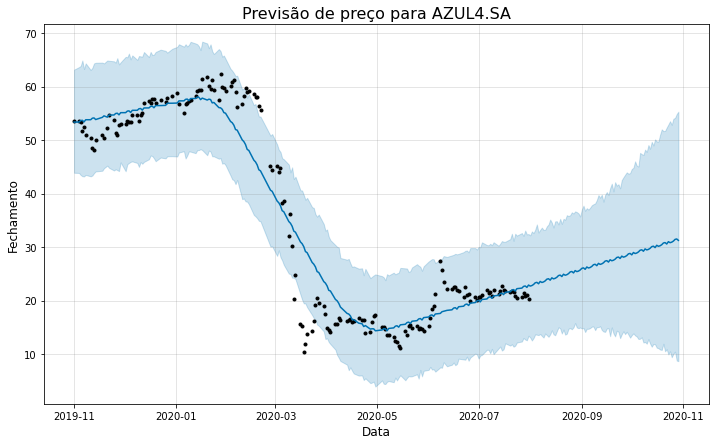

In [148]:
# Plot da previsao feita pelo facebook prophet
plot_prophet(azul_model, azul_forecast, "Previsão de preço para AZUL4.SA", "Data", "Fechamento")

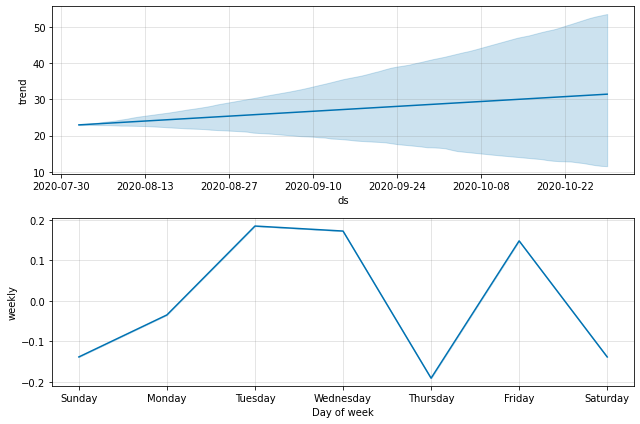

In [149]:
# Plot de componentes da variacao

azul_forecast = get_test_period(azul_forecast, train_end_date)
plot_forest_components(azul_model, azul_forecast)

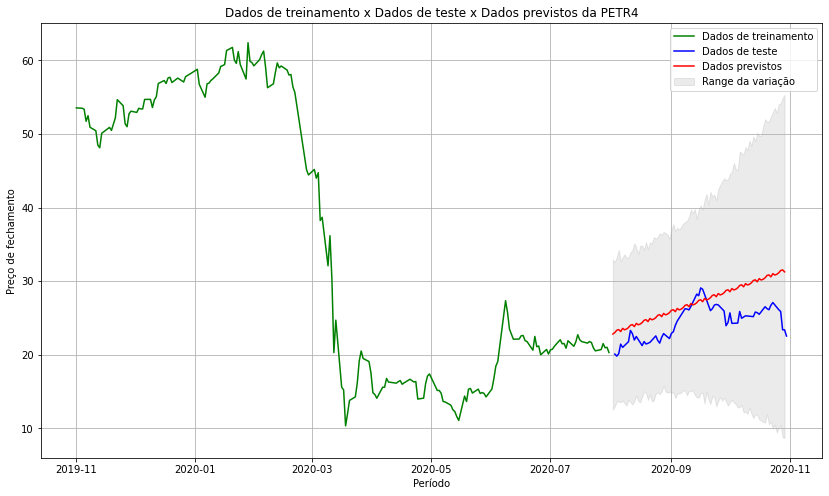

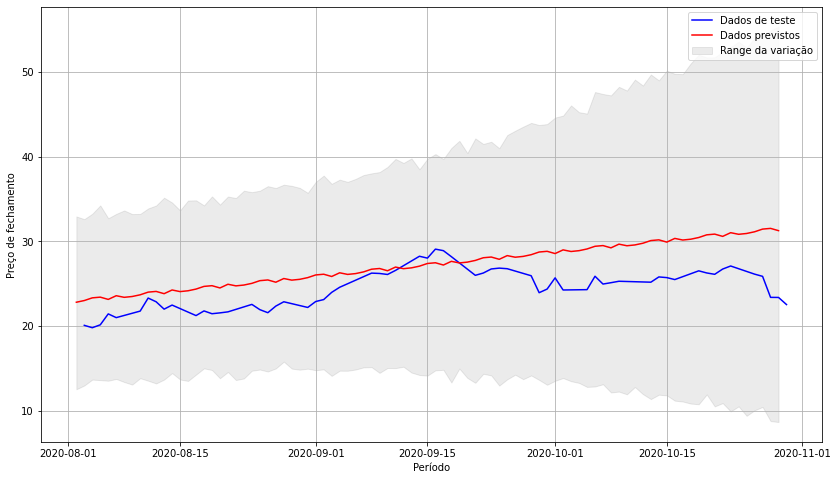

In [150]:
azul_forecast = azul_forecast.dropna()
azul_forecast.set_index(azul_forecast['ds'], inplace=True) 
train_azul_prophet.set_index(train_azul_prophet['ds'], inplace=True) 
test_azul_prophet.set_index(test_azul_prophet['ds'], inplace=True) 

plot_compar_data_train_test(train_azul_prophet, 
                            test_azul_prophet, 
                            azul_forecast, 
                            "Dados de treinamento x Dados de teste x Dados previstos da PETR4", 
                            "Período", 
                            "Preço de fechamento", 
                             False)

#### 5.1.2.2 Usando Arima

In [151]:
train_azul_arima = train_azul
test_azul_arima = test_azul

train_azul_arima = train_azul_arima.drop(non_use_columns, axis=1)
test_azul_arima = test_azul_arima.drop(non_use_columns, axis=1)

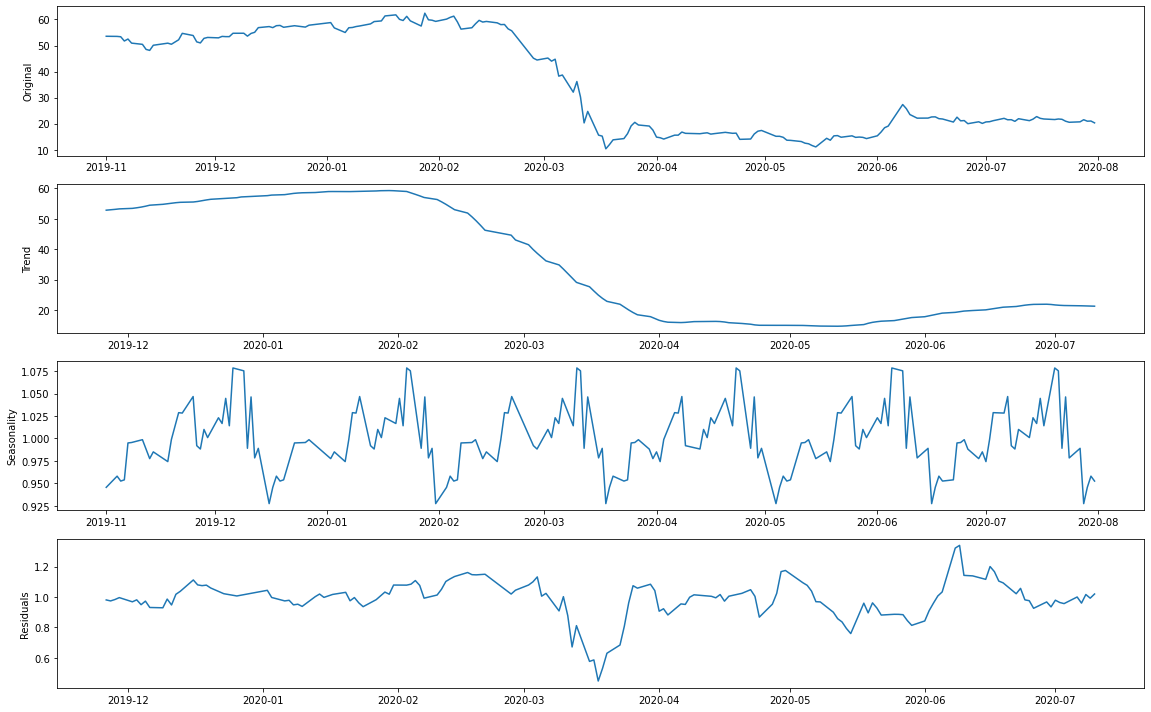

In [152]:
decompse_dataset(train_azul_arima, 30)

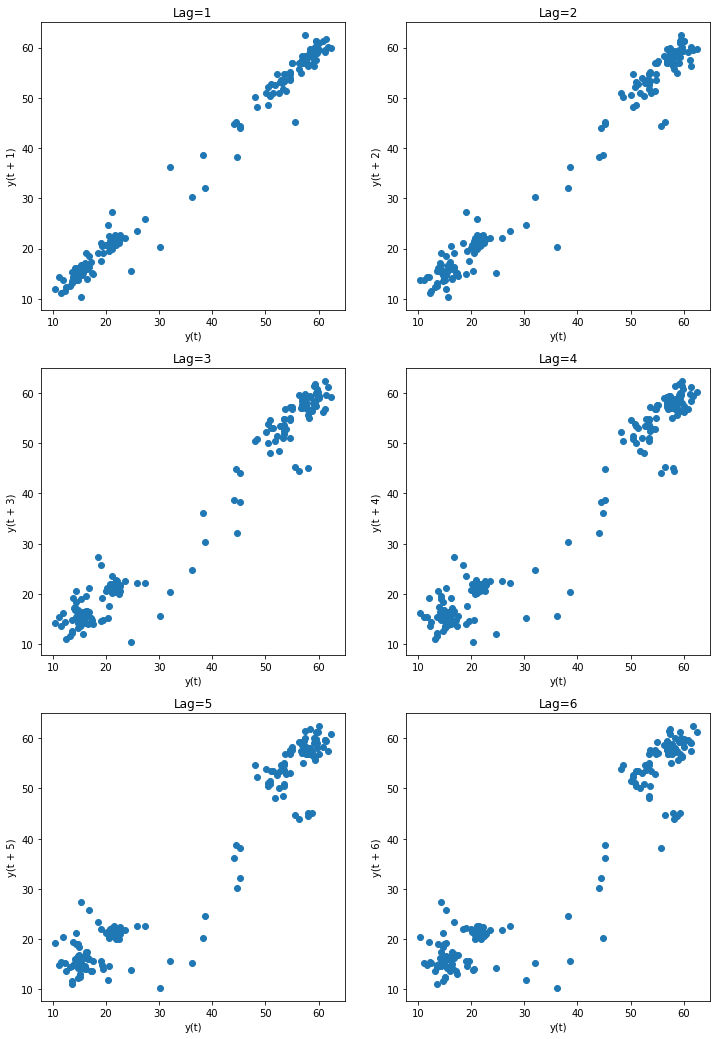

In [153]:
correlation_close_variable("Relação entre as variáveis", train_azul_arima)

In [154]:
# Verificar estacionaridade
adf_test(train_azul_arima)

Resultado do Teste Dickey-Fuller:
Teste                   -0.867679
Valor p                  0.798430
Nº de lags               8.000000
Nº de observações      174.000000
Valor Crítico (1%)      -3.468502
Valor Crítico (5%)      -2.878298
Valor Crítico (10%)     -2.575704
dtype: float64


In [155]:
train_azul_diff = apply_diff_dataset(train_azul_arima)
adf_test(train_azul_diff)

Resultado do Teste Dickey-Fuller:
Teste                   -4.266834
Valor p                  0.000507
Nº de lags               7.000000
Nº de observações      174.000000
Valor Crítico (1%)      -3.468502
Valor Crítico (5%)      -2.878298
Valor Crítico (10%)     -2.575704
dtype: float64


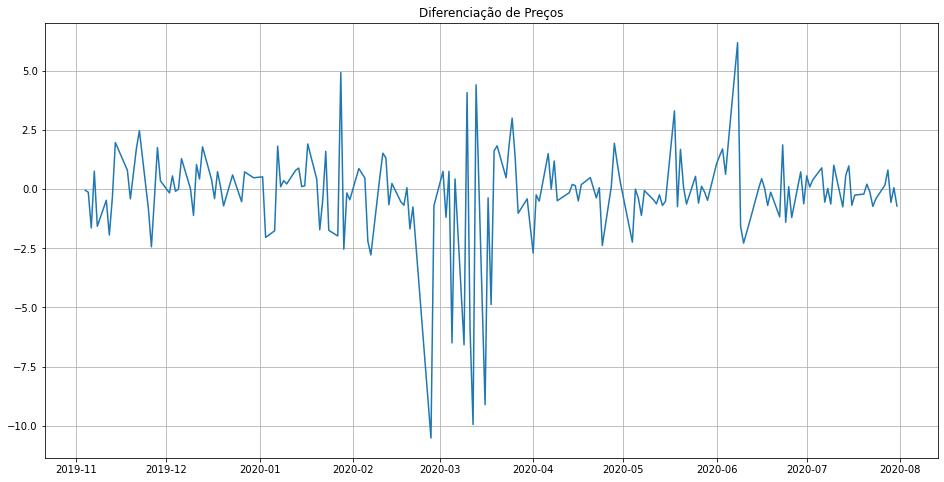

In [156]:
plot_diff("Diferenciação de Preços", train_azul_diff)

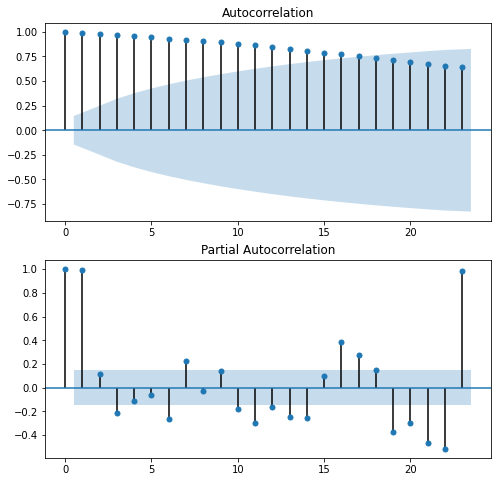

In [157]:
plot_acf_pacf(train_azul_arima)

In [158]:
azul_model_arima = create_arima_model(train_azul_arima)
azul_forecast_arima = create_prediction_arima(azul_model_arima, test_azul_arima)
azul_conf = get_conf(azul_model_arima, test_azul_arima)
azul_model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=815.494, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=787.723, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=815.083, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=779.138, Time=0.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.96 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=780.030, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=777.878, Time=0.48 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=784.879, Time=0.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.00 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=778.007, Time=0.54 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=773.972, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  183
Model:             SARIMAX(1, 1, 2)x(2, 1, [], 12)   Log Likelihood                -380.654
Date:                             Mon, 01 Mar 2021   AIC                            773.307
Time:                                     18:22:20   BIC                            792.122
Sample:                                          0   HQIC                           780.942
                                             - 183                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8319      0.101      8.228      0.000       0.634       1.030
ma.L1         -1.0044      0.109     -9.206      0.000      -1.218      -0.791
ma.L2          0.2736      0.074      3.718      0.000       0.129       0.418
ar.S.L12      -0.5211      0.071     -7.290      0.000      -0.661      -0.381
ar.S.L24      -0.2270      0.068     -3.333      0.001      -0.361      -0.094
sigma2         5.0442      0.401     12.594      0.000       4.259       5.829
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                76.13
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.59
Prob(H) (two-sided):                  0.95   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

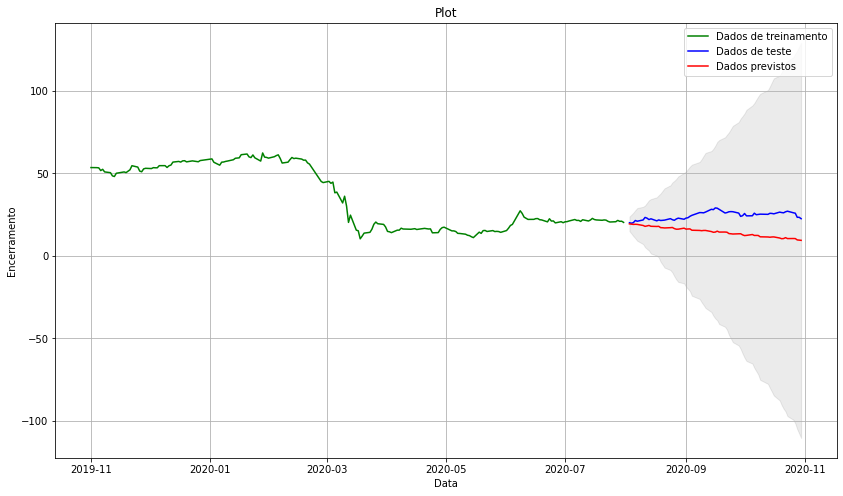

In [159]:
plot_arima_predict(train_azul_arima, 
                   test_azul_arima, 
                   azul_forecast_arima, 
                   azul_conf, 
                   "Plot", 
                   "Data", 
                   "Encerramento")

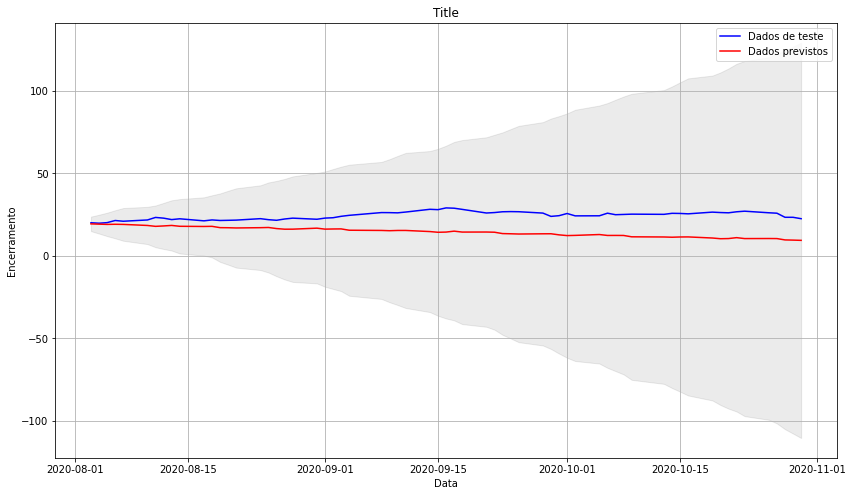

In [160]:
plot_test_predict(test_azul_arima, azul_forecast_arima, azul_conf, "Title", "Data", "Encerramento")

In [161]:
print_score_confidencility(test_azul_arima, azul_forecast_arima)

MSE: 119.19740919913755
MAE: 9.855368814792707
RMSE: 10.917756601020997


## 5.2 GOL

In [162]:
## Variação do encerramento da ação no período
variation_chart(dataset_gol)

In [163]:
## Comparação entre os valores da ação no período
values_comparission_chart(dataset_gol, 'Date', 'Open', features)

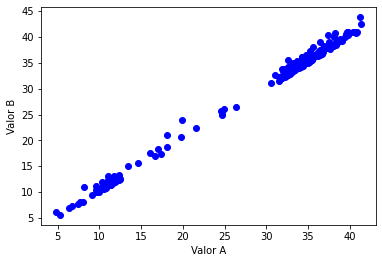

In [164]:
## Correlação entre os valores
correlation_chart(dataset_gol[:-100], 'Low', 'Close')

In [165]:
## Gráfico candle stick para comparação do dia a dia da ação
candle_chart(dataset_gol)

In [166]:
## Variação da ação no dia
diff_sub_chart(dataset_gol, 'Close', 'Open')
dataset_gol.head(172)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Diff
0,2019-07-01,32.910000,33.099998,31.700001,31.910000,3203800,0,0,-1.000000
1,2019-07-02,31.990000,32.410000,31.520000,32.340000,3242100,0,0,0.350000
2,2019-07-03,32.599998,35.439999,32.580002,35.439999,7308800,0,0,2.840000
3,2019-07-04,35.599998,38.029999,35.599998,38.029999,4706500,0,0,2.430000
4,2019-07-05,38.720001,41.639999,37.450001,40.400002,15193600,0,0,1.680000
...,...,...,...,...,...,...,...,...,...
167,2020-03-04,26.000000,26.209999,24.719999,24.809999,9269800,0,0,-1.190001
168,2020-03-05,24.200001,24.400000,19.820000,20.650000,13712100,0,0,-3.550001
169,2020-03-06,18.100000,21.719999,18.100000,21.049999,14833900,0,0,2.949999
170,2020-03-09,19.500000,19.660000,17.360001,17.379999,7560100,0,0,-2.120001


### 5.2.3 Gol Predição

In [167]:
#Carregamento dos dados de treinamento e teste
train_gol = get_company_history('GOLL4.SA', train_start_date, train_end_date, False)
test_gol = get_company_history('GOLL4.SA', test_start_date, test_end_date, False)

#### 5.2.3.1 Usando Prophet

In [168]:
#Carregamento dos dados de treinamento e teste
train_gol_prophet = train_gol
test_gol_prophet = test_gol

train_gol_prophet = create_dataset_facebook_prophet(train_gol_prophet)
test_gol_prophet = create_dataset_facebook_prophet(test_gol_prophet)

In [169]:
# Cria modelo prophet e predicoes
gol_model = make_model_prophet(train_gol_prophet)
gol_forecast = make_forecast_in_period(gol_model, 90)
gol_forecast = gol_model.predict(gol_forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


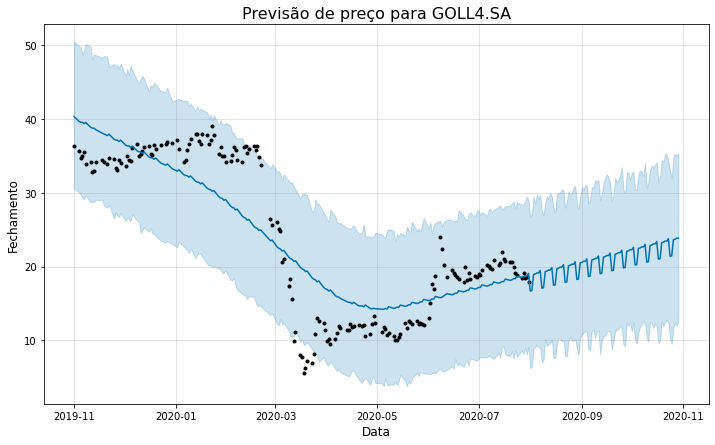

In [170]:
# Plot da previsao feita pelo facebook prophet
plot_prophet(gol_model, gol_forecast, "Previsão de preço para GOLL4.SA", "Data", "Fechamento")

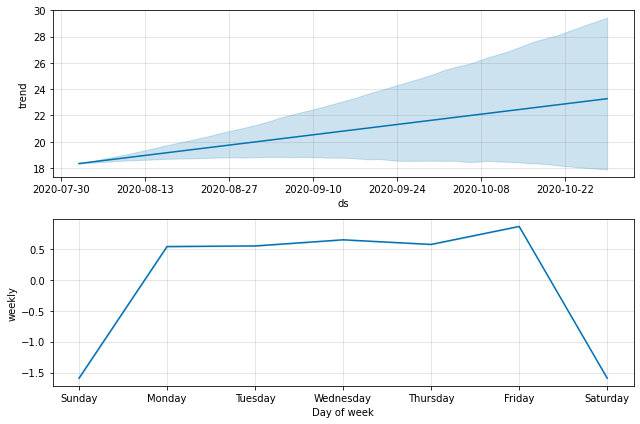

In [171]:
# Plot de componentes da variacao

gol_forecast = get_test_period(gol_forecast, train_end_date)
plot_forest_components(gol_model, gol_forecast)

In [172]:
#Exclusão dos fins de semana nos dados previstos
gol_forecast = gol_forecast[gol_forecast['ds'].dt.dayofweek < 5]

#Exclusão dos feriados nos dados previstos
holidays = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(['2019-01-01','2019-01-25','2019-03-04','2019-03-05','2019-04-19','2019-05-01','2019-06-20','2019-07-09','2019-11-15','2019-11-20','2019-12-24','2019-12-25','2019-12-31']),
})

gol_forecast = gol_forecast[~gol_forecast['ds'].isin(holidays['ds'])]
gol_forecast = gol_forecast.dropna()

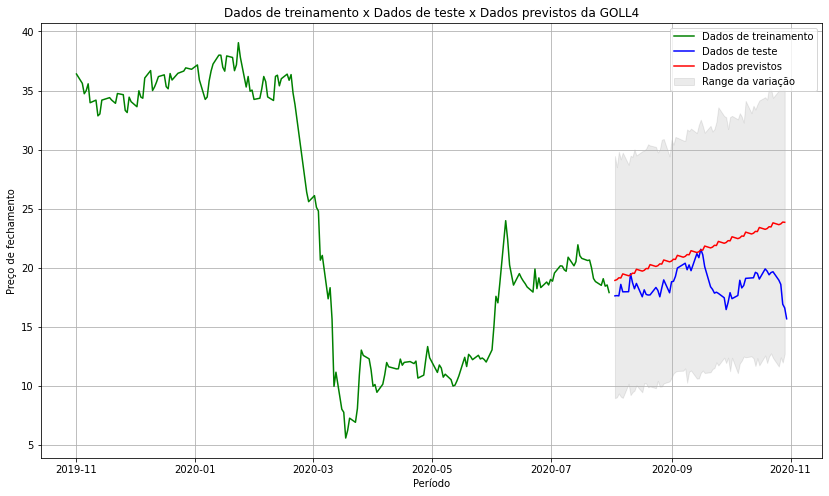

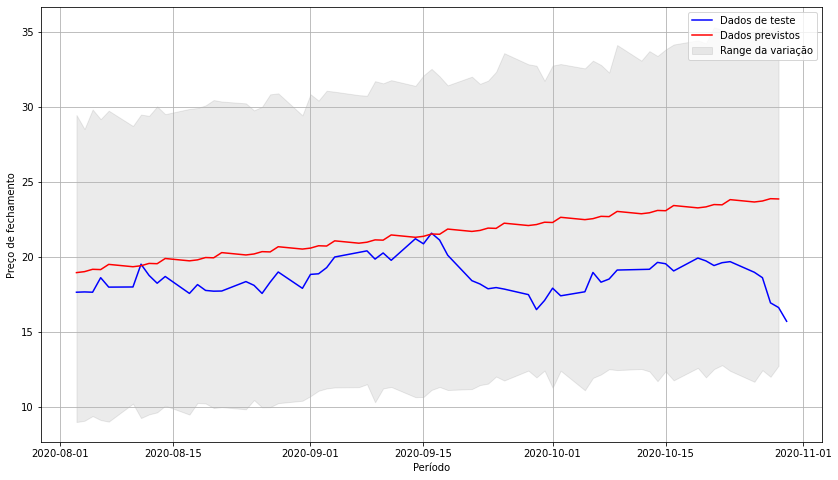

In [173]:
gol_forecast.set_index(gol_forecast['ds'], inplace=True) 
train_gol_prophet.set_index(train_gol_prophet['ds'], inplace=True) 
test_gol_prophet.set_index(test_gol_prophet['ds'], inplace=True) 

plot_compar_data_train_test(train_gol_prophet, 
                            test_gol_prophet, 
                            gol_forecast, 
                            "Dados de treinamento x Dados de teste x Dados previstos da GOLL4", 
                            "Período", 
                            "Preço de fechamento", 
                             False)

#### 5.2.3.2 Usando Arima

In [174]:
train_gol_arima = train_gol
test_gol_arima = test_gol

train_gol_arima = train_gol_arima.drop(non_use_columns, axis=1)
test_gol_arima = test_gol_arima.drop(non_use_columns, axis=1)

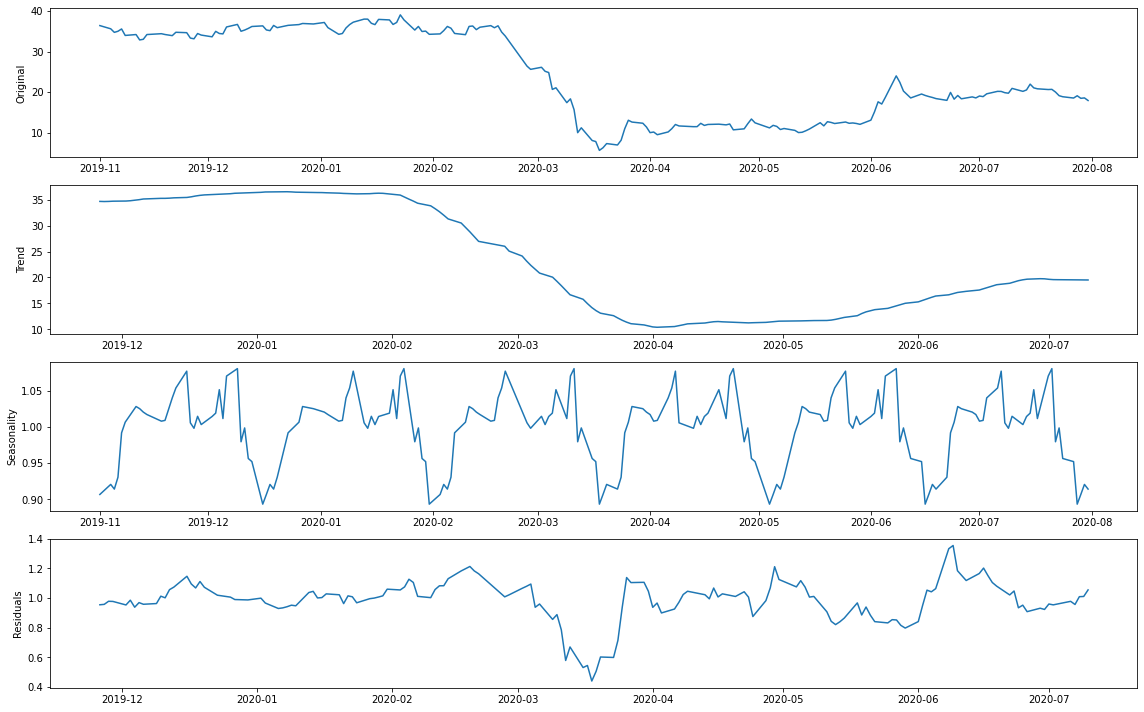

In [175]:
decompse_dataset(train_gol_arima, 30)

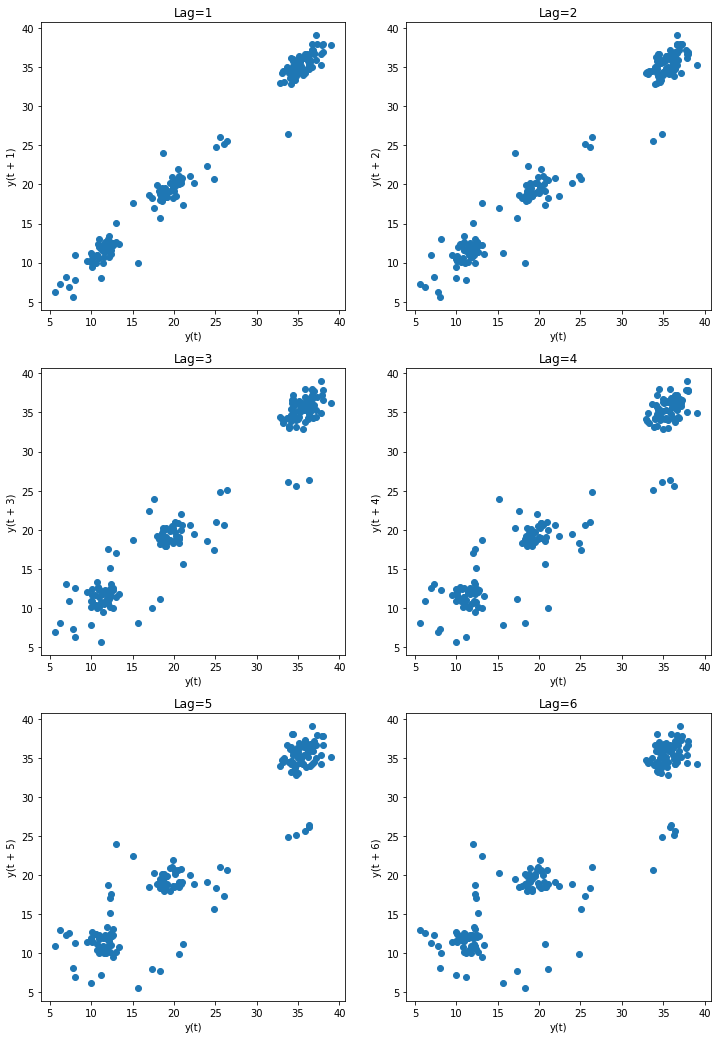

In [176]:
correlation_close_variable("Relação entre as variáveis", train_gol_arima)

In [177]:
# Verificar estacionaridade
adf_test(train_gol_arima)

Resultado do Teste Dickey-Fuller:
Teste                   -1.526305
Valor p                  0.520461
Nº de lags              10.000000
Nº de observações      172.000000
Valor Crítico (1%)      -3.468952
Valor Crítico (5%)      -2.878495
Valor Crítico (10%)     -2.575809
dtype: float64


In [178]:
train_gol_diff = apply_diff_dataset(train_gol_arima)
adf_test(train_gol_arima)

Resultado do Teste Dickey-Fuller:
Teste                   -1.526305
Valor p                  0.520461
Nº de lags              10.000000
Nº de observações      172.000000
Valor Crítico (1%)      -3.468952
Valor Crítico (5%)      -2.878495
Valor Crítico (10%)     -2.575809
dtype: float64


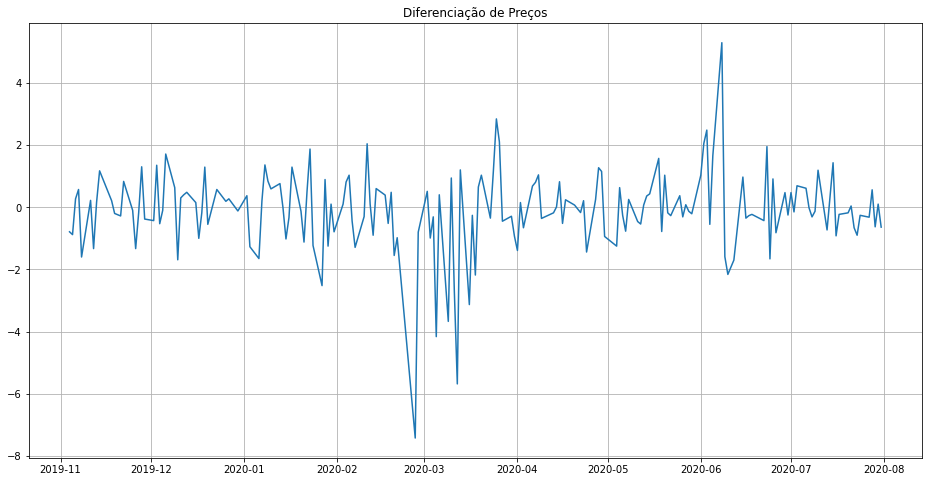

In [179]:
plot_diff("Diferenciação de Preços", train_gol_diff)

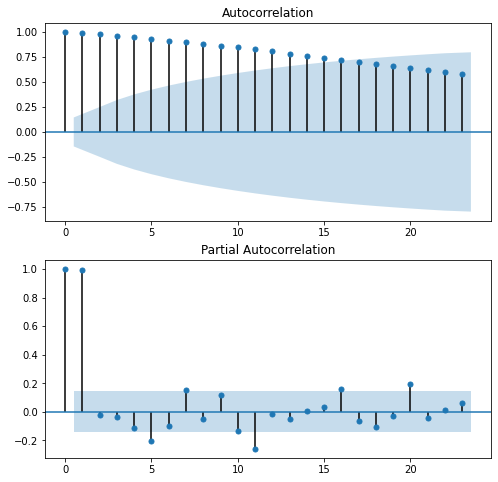

In [180]:
plot_acf_pacf(train_gol_arima)

In [181]:
gol_model_arima = create_arima_model(train_gol_arima)
gol_forecast_arima = create_prediction_arima(gol_model_arima, test_gol_arima)
gol_conf = get_conf(gol_model_arima, test_gol_arima)
gol_model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=690.231, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=652.887, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=690.945, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=641.881, Time=0.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=640.258, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=650.992, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.77 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=641.892, Time=0.33 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=640.553, Time=1.09 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=642.250, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  183
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -317.129
Date:                            Mon, 01 Mar 2021   AIC                            640.258
Time:                                    18:22:41   BIC                            649.666
Sample:                                         0   HQIC                           644.076
                                            - 183                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5900      0.062     -9.478      0.000      -0.712      -0.468
ar.S.L24      -0.2651      0.063     -4.190      0.000      -0.389      -0.141
sigma2         2.3761      0.170     13.988      0.000       2.043       2.709
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                59.17
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.60
Prob(H) (two-sided):                  0.24   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

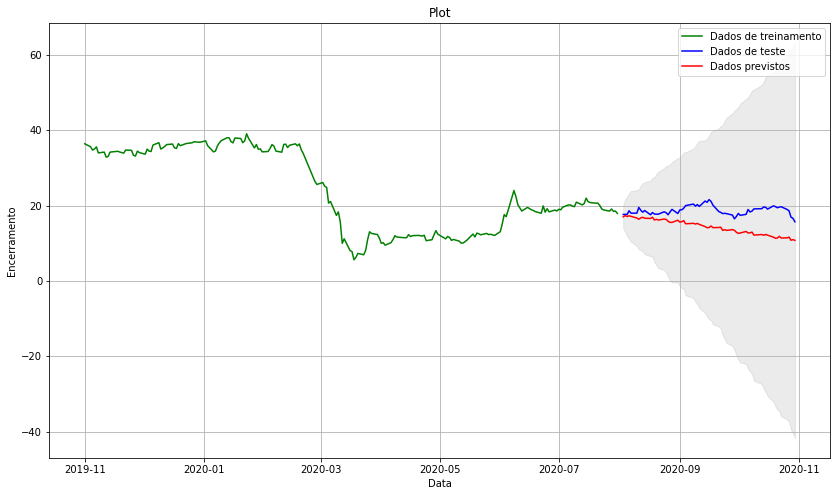

In [182]:
plot_arima_predict(train_gol_arima, 
                   test_gol_arima, 
                   gol_forecast_arima, 
                   gol_conf, 
                   "Plot", 
                   "Data", 
                   "Encerramento")

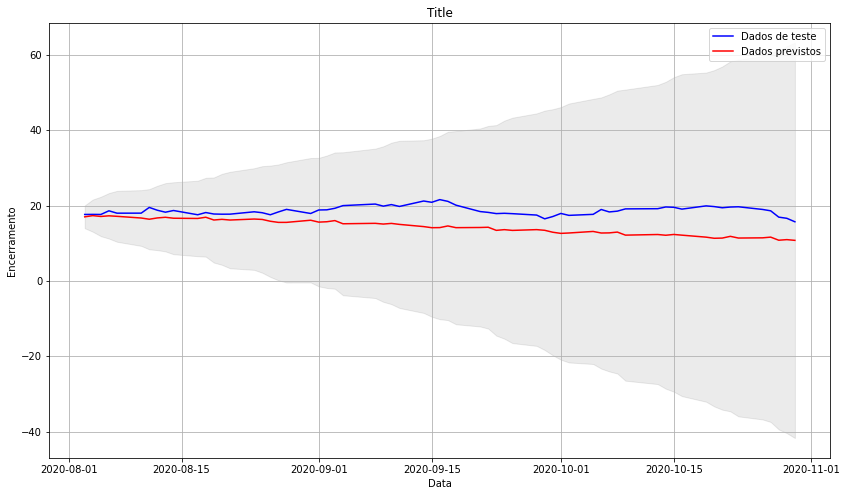

In [183]:
plot_test_predict(test_gol_arima, gol_forecast_arima, gol_conf, "Title", "Data", "Encerramento")

In [206]:
print_score_confidencility(test_gol_arima, gol_forecast_arima)

MSE: 24.33187063949158
MAE: 4.336668177807441
RMSE: 4.93273460055288


## 5.3 Embraer

In [184]:
## Variação do encerramento da ação no período
variation_chart(dataset_embraer)

In [185]:
## Comparação entre os valores da ação no período
values_comparission_chart(dataset_embraer, 'Date', 'Open', features)

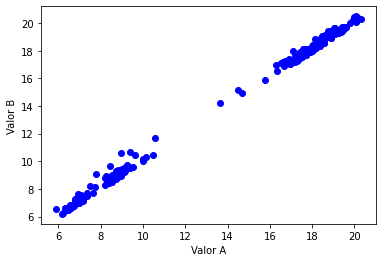

In [186]:
## Correlação entre os valores
correlation_chart(dataset_embraer[:-100], 'Low', 'Close')

In [187]:
## Gráfico candle stick para comparação do dia a dia da ação
candle_chart(dataset_embraer)

In [188]:
## Variação da ação no dia
diff_sub_chart(dataset_embraer, 'Close', 'Open')

### 5.3.1 Embraer Predição

In [189]:
#Carregamento dos dados de treinamento e teste
train_embraer = get_company_history('EMBR3.SA', train_start_date, train_end_date, False)
test_embraer = get_company_history('EMBR3.SA', test_start_date, test_end_date, False)

#### 5.3.1.1 Usando o Prophet

In [190]:
train_embraer_prophet = train_embraer
test_embraer_prophet = test_embraer

train_embraer_prophet = create_dataset_facebook_prophet(train_embraer_prophet)
test_embraer_prophet = create_dataset_facebook_prophet(test_embraer_prophet)

In [191]:
# Cria modelo prophet e predicoes
embraer_model = make_model_prophet(train_embraer_prophet)
embraer_forecast = make_forecast_in_period(embraer_model, 90)
embraer_forecast = embraer_model.predict(embraer_forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


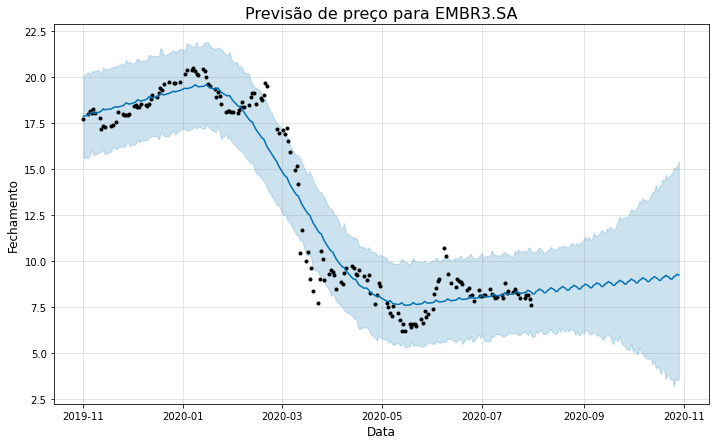

In [192]:
# Plot da previsao feita pelo facebook prophet
plot_prophet(embraer_model, embraer_forecast, "Previsão de preço para EMBR3.SA", "Data", "Fechamento")

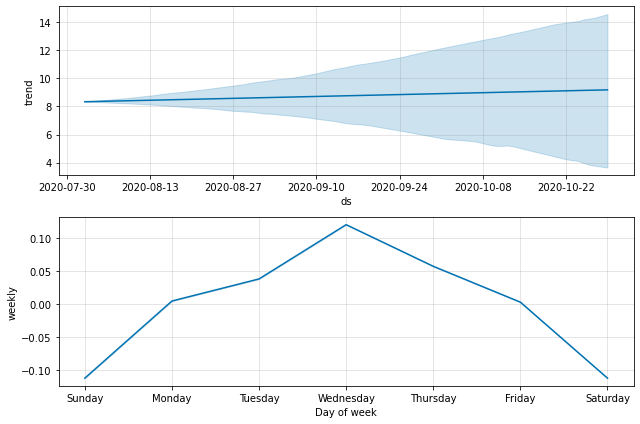

In [193]:
# Plot de componentes da variacao

embraer_forecast = get_test_period(embraer_forecast, train_end_date)
plot_forest_components(embraer_model, embraer_forecast)

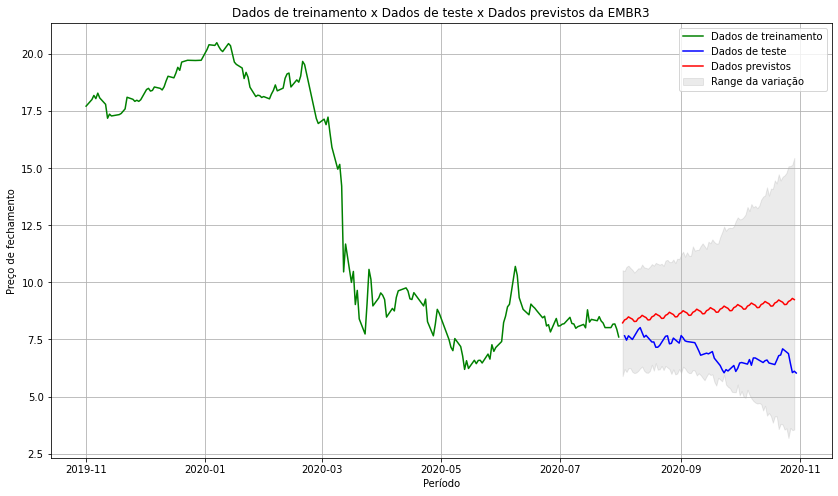

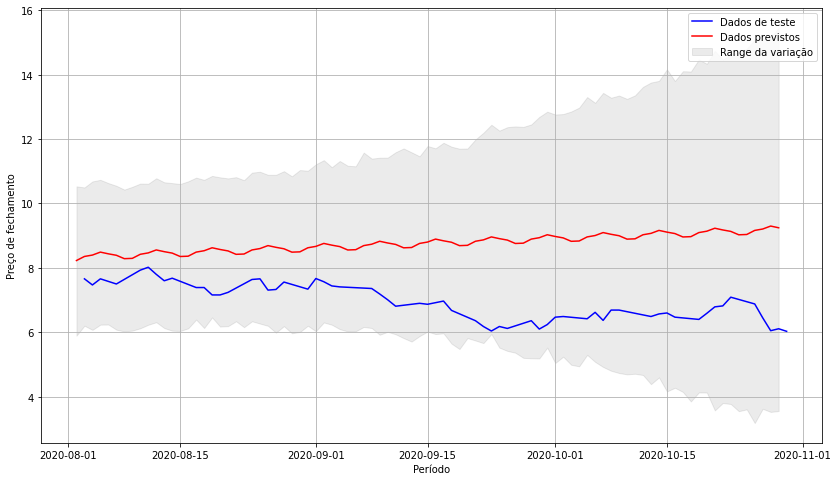

In [194]:
embraer_forecast = embraer_forecast.dropna()
embraer_forecast.set_index(embraer_forecast['ds'], inplace=True) 
train_embraer_prophet.set_index(train_embraer_prophet['ds'], inplace=True) 
test_embraer_prophet.set_index(test_embraer_prophet['ds'], inplace=True) 

plot_compar_data_train_test(train_embraer_prophet, 
                            test_embraer_prophet, 
                            embraer_forecast, 
                            "Dados de treinamento x Dados de teste x Dados previstos da EMBR3", 
                            "Período", 
                            "Preço de fechamento", 
                             False)

#### 5.3.1.2 Usando Arima

In [195]:
train_embraer_arima = train_embraer
test_embraer_arima = test_embraer

train_embraer_arima = train_embraer_arima.drop(non_use_columns, axis=1)
test_embraer_arima = test_embraer_arima.drop(non_use_columns, axis=1)

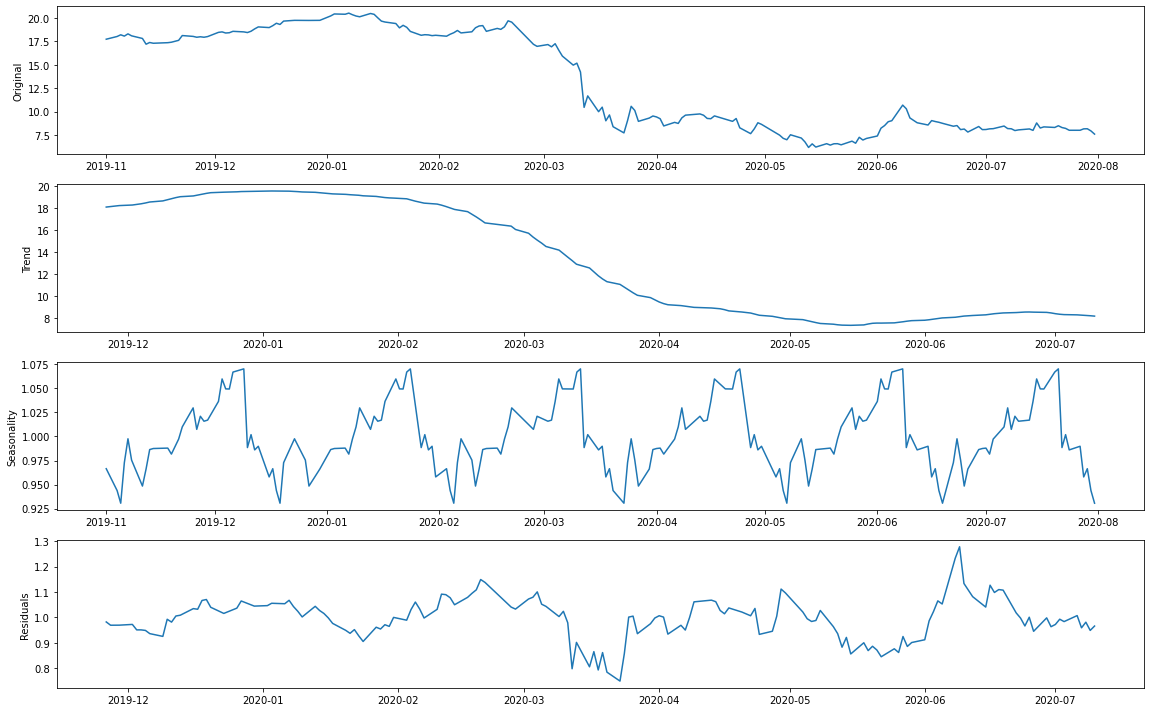

In [196]:
decompse_dataset(train_embraer_arima, 30)

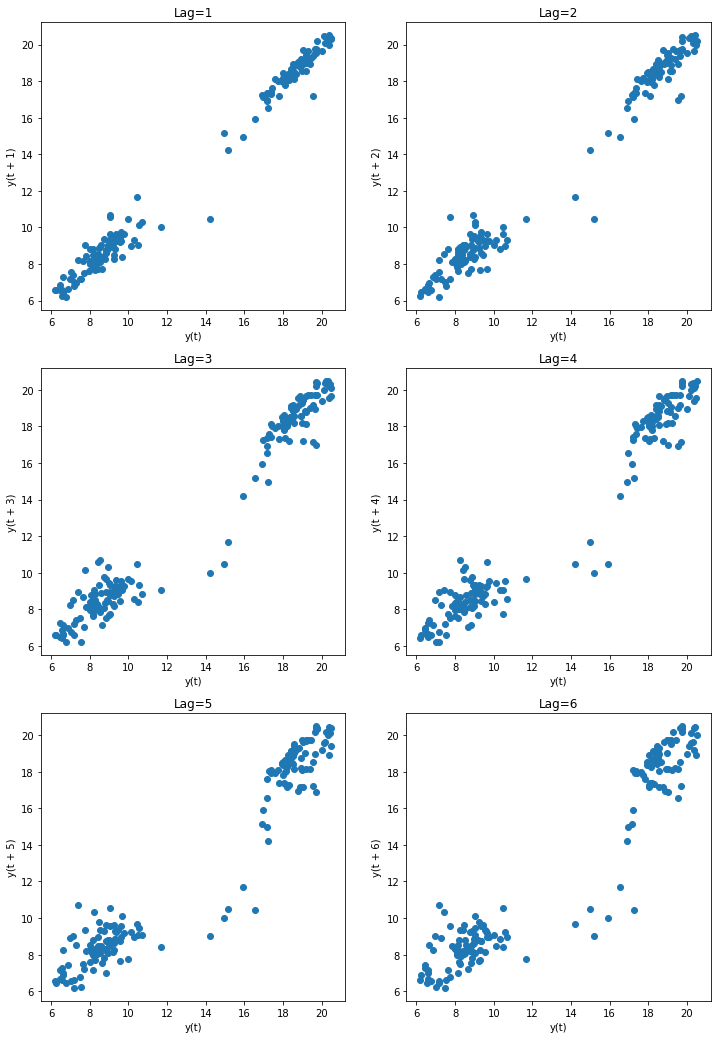

In [197]:
correlation_close_variable("Relação entre as variáveis", train_embraer_arima)

In [198]:
# Verificar estacionaridade
adf_test(train_embraer_arima)

Resultado do Teste Dickey-Fuller:
Teste                   -0.915187
Valor p                  0.782930
Nº de lags              10.000000
Nº de observações      172.000000
Valor Crítico (1%)      -3.468952
Valor Crítico (5%)      -2.878495
Valor Crítico (10%)     -2.575809
dtype: float64


In [199]:
train_embraer_diff = apply_diff_dataset(train_embraer_arima)
adf_test(train_embraer_arima)

Resultado do Teste Dickey-Fuller:
Teste                   -0.915187
Valor p                  0.782930
Nº de lags              10.000000
Nº de observações      172.000000
Valor Crítico (1%)      -3.468952
Valor Crítico (5%)      -2.878495
Valor Crítico (10%)     -2.575809
dtype: float64


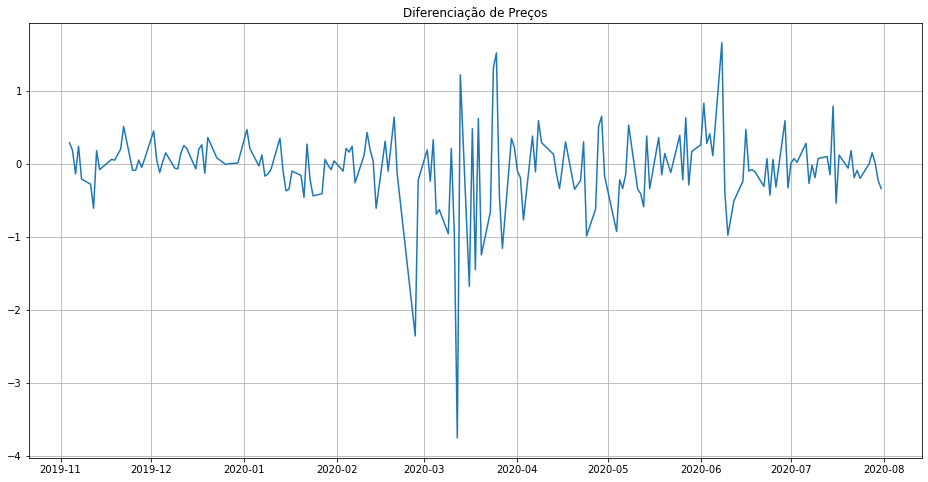

In [200]:
plot_diff("Diferenciação de Preços", train_embraer_diff)

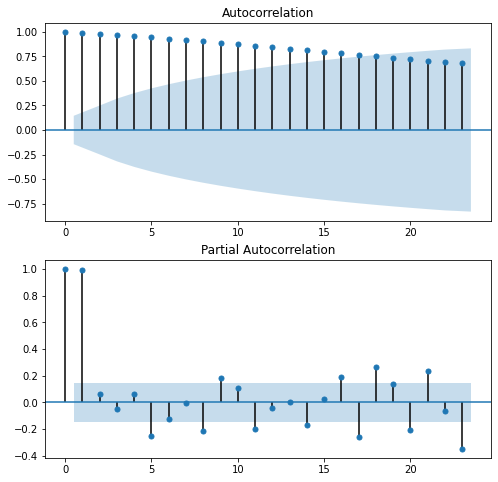

In [201]:
plot_acf_pacf(train_embraer_arima)

In [202]:
embraer_model_arima = create_arima_model(train_embraer_arima)
embraer_forecast_arima = create_prediction_arima(embraer_model_arima, test_embraer_arima)
embraer_conf = get_conf(embraer_model_arima, test_embraer_arima)
embraer_model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=416.722, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=375.537, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=418.049, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=353.040, Time=0.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.92 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=352.159, Time=0.27 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=374.158, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.88 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=352.991, Time=0.38 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=354.917, Time=0.74 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=354.090, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  183
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -173.080
Date:                            Mon, 01 Mar 2021   AIC                            352.159
Time:                                    18:23:03   BIC                            361.566
Sample:                                         0   HQIC                           355.977
                                            - 183                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6519      0.057    -11.421      0.000      -0.764      -0.540
ar.S.L24      -0.3471      0.062     -5.601      0.000      -0.468      -0.226
sigma2         0.4323      0.022     19.273      0.000       0.388       0.476
===================================================================================
Ljung-Box (L1) (Q):                   1.14   Jarque-Bera (JB):               519.63
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

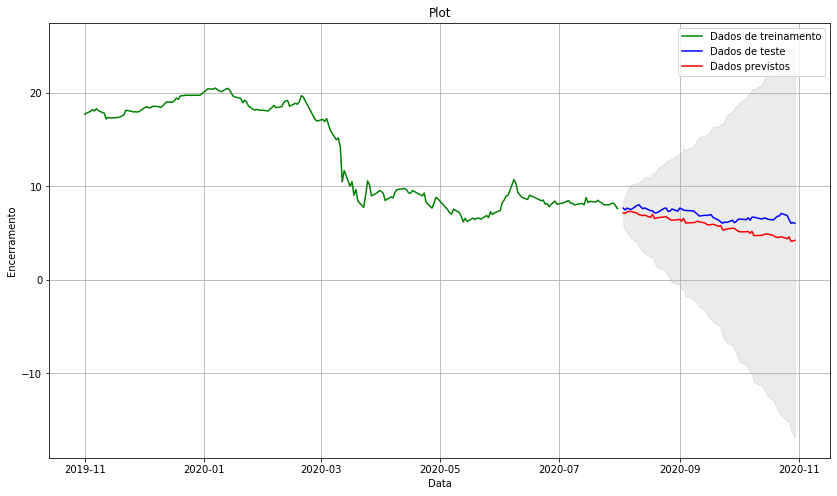

In [203]:
plot_arima_predict(train_embraer_arima, test_embraer_arima, embraer_forecast_arima, embraer_conf, "Plot", "Data", "Encerramento")

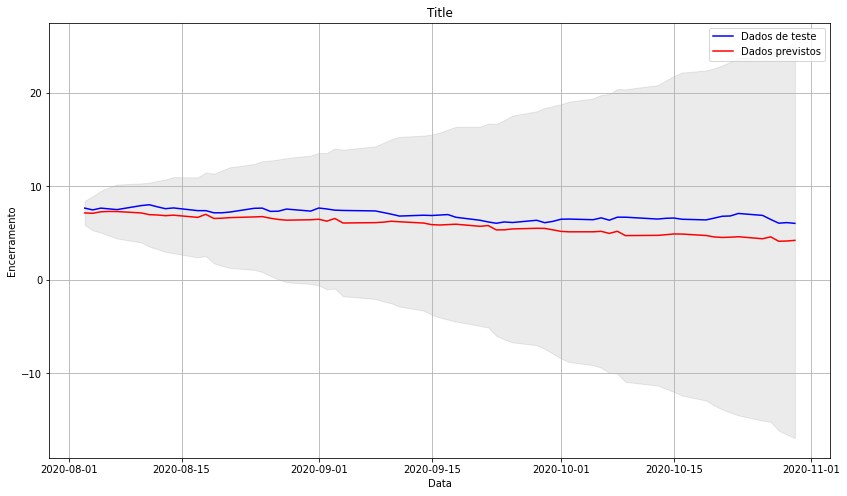

In [204]:
plot_test_predict(test_embraer_arima, embraer_forecast_arima, embraer_conf, "Title", "Data", "Encerramento")

In [207]:
print_score_confidencility(test_embraer_arima, embraer_forecast_arima)

MSE: 1.5894583829736806
MAE: 1.1268745190051368
RMSE: 1.260737237878568


# 6 - Correlação

In [205]:
stocks = {'Azul':  dataset_azul['Close'],
          'Gol': dataset_gol['Close'],
          'Embraer': dataset_embraer['Close'],
          'Date': dataset_azul['Date']
        }
df = pd.DataFrame(stocks, columns = ['Azul', 'Gol', 'Embraer', 'Date'])

values_comparission_chart(df, 'Date', 'Azul', ['Azul', 'Gol', 'Embraer'])